#  Прогнозирование заказов такси

Необходимо создать модель, которая спрогнозирует количество зазказов такси на следующий час, учитывая исторические данные о заказах такси в аэропортах.



## Подготовка

Посмотрим, что у нас есть, и импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.sort_index(inplace=True)

In [ ]:
df=df.resample('1H').sum() #resample по 1 часу

<AxesSubplot:xlabel='datetime'>

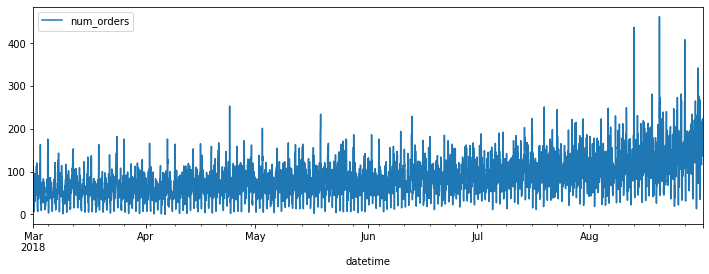

In [ ]:
df.plot(figsize=(12, 4))

## Анализ

Посмотрим, есть ли тренды и сезонность через функцию seasonal_decompose

In [ ]:
decomposed = seasonal_decompose(df)


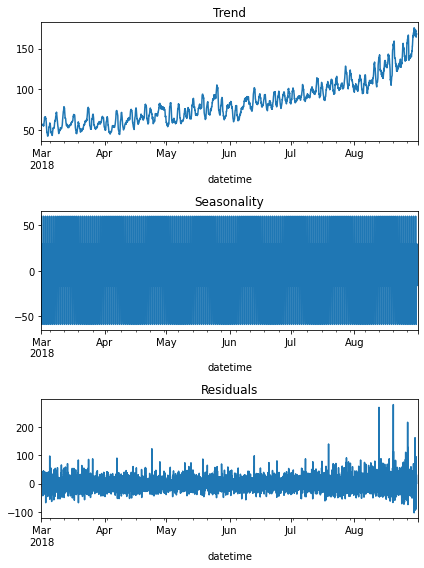

In [ ]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

## Обучение

Разделим данные на выборки. 

прибавим к таблице новых календарные признаки, lag_features и скользящее среднее

In [ ]:
df_1 = df

In [ ]:
def make_features(df_1, max_lag, rolling_mean_size):
    df_1['year'] = df_1.index.year
    df_1['month'] = df_1.index.month
    df_1['day'] = df_1.index.day
    df_1['dayofweek'] = df_1.index.dayofweek
    df_1['hour'] = df_1.index.hour
    
    for lag in range(1, max_lag + 1):
        df_1['lag_{}'.format(lag)] = df_1['num_orders'].shift(lag)

    df_1['rolling_mean'] = df_1['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_1, 4, 4)
features = df_1.drop('num_orders', axis=1) 
target = df_1['num_orders']
df_1, test = train_test_split(df_1, test_size=0.1, train_size=0.9, shuffle=False)
train, valid = train_test_split(df_1, test_size=0.2, train_size=0.8, shuffle=False)
train = train.dropna()
print(train.shape)
print(test.shape)
print(valid.shape)

(3175, 11)
(442, 11)
(795, 11)


Спрогнозируем новое значение предыдущим

In [ ]:
print(df.shape)

(4416, 11)


In [ ]:
print("Среднее количество заказов в час:", test['num_orders'].mean())
pred_previous = valid.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:",mean_squared_error(valid, pred_previous)**0.5) 

Среднее количество заказов в час: 139.55656108597285
RMSE: 31.31822889045233


In [ ]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

обучим модели

In [ ]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid) 
    result = mean_squared_error(target_valid, predictions_valid)**0.5 
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

RMSE наилучшей модели на валидационной выборке: 34.21367371864936 Глубина дерева: 10


In [ ]:
model = DecisionTreeRegressor(random_state=12345, max_depth=10) 
model.fit(features_train, target_train)
predictions1_valid = model.predict(features_valid) 
print('RMSE DecisionTreeRegressor', mean_squared_error(target_valid, predictions1_valid)**0.5)

RMSE DecisionTreeRegressor 34.21367371864936


In [ ]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions_valid)**0.5 
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

RMSE наилучшей модели на валидационной выборке: 32.88679818164978 Количество деревьев: 40 Максимальная глубина: 10


In [ ]:
model = RandomForestRegressor(random_state=12345, n_estimators=40, max_depth=10) 
model.fit(features_train, target_train)
predictions2_valid = model.predict(features_valid) 
print('RMSE RandomForestRegressor', mean_squared_error(target_valid, predictions2_valid)**0.5)

RMSE RandomForestRegressor 32.88679818164978


In [ ]:
model = LinearRegression() 
model.fit(features_train, target_train)
predictions3_valid = model.predict(features_valid) 
print('RMSE LinearRegression', mean_squared_error(target_valid, predictions3_valid)**0.5)

RMSE LinearRegression 38.854941364646635


In [ ]:
model = CatBoostRegressor(loss_function="RMSE", iterations=100, learning_rate=1, depth=6)

model.fit(features_train, target_train, verbose=10)

probabilities_valid = model.predict(features_valid)

print('RMSE CatBoostRegressor', mean_squared_error(target_valid, probabilities_valid)**0.5)

0:	learn: 25.4408952	total: 48.8ms	remaining: 4.83s
10:	learn: 18.6220842	total: 65ms	remaining: 526ms
20:	learn: 16.4995397	total: 80.6ms	remaining: 303ms
30:	learn: 14.7878057	total: 95.8ms	remaining: 213ms
40:	learn: 13.5782855	total: 110ms	remaining: 159ms
50:	learn: 12.6117626	total: 125ms	remaining: 120ms
60:	learn: 11.6177664	total: 139ms	remaining: 89.1ms
70:	learn: 10.7991472	total: 155ms	remaining: 63.2ms
80:	learn: 10.1296926	total: 170ms	remaining: 39.8ms
90:	learn: 9.4773064	total: 185ms	remaining: 18.2ms
99:	learn: 8.9046267	total: 198ms	remaining: 0us
RMSE CatBoostRegressor 34.93215198771223


In [ ]:
model=LGBMRegressor(learning_rate=1, max_depth=6)

model.fit(features_train, target_train)

valid_preds = model.predict(features_valid)
print('RMSE LGBMRegressor', mean_squared_error(target_valid, valid_preds)**0.5)

RMSE LGBMRegressor 38.7023475606003


## Тестирование

протестируем модели на тестовой выборке

In [ ]:
train, test = train_test_split(df_1, test_size=0.1, train_size=0.9, shuffle=False)
train = train.dropna()
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']


In [ ]:
train.shape

(3572, 11)

In [ ]:
model = DecisionTreeRegressor(random_state=12345, max_depth=13) 
model.fit(features_train, target_train)
predicted_test_dtr = model.predict(features_test)
result_dtr = mean_squared_error(target_test, predicted_test_dtr)**0.5
print('RMSE DecisionTreeRegressor', (result_dtr))

RMSE DecisionTreeRegressor 42.529882272044155


In [ ]:
model = RandomForestRegressor(random_state=12345, n_estimators=10, max_depth=199) 
model.fit(features_train, target_train)
predicted_test_rfr = model.predict(features_test)
result_rfr = mean_squared_error(target_test, predicted_test_rfr)**0.5
print('RMSE RandomForestRegressor', result_rfr)

RMSE RandomForestRegressor 35.34615791563469


In [ ]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_test_lr = model.predict(features_test)
result_lr = mean_squared_error(target_test, predicted_test_lr)**0.5
print('RMSE Linear Regression', result_lr)

RMSE Linear Regression 40.98463952904735


In [ ]:
model = CatBoostRegressor(loss_function="RMSE", iterations=100, learning_rate=1, depth=15, verbose=10)
model.fit(features_train, target_train)
predicted_test_cbr = model.predict(features_test)
result_cbr = mean_squared_error(target_test, predicted_test_cbr)**0.5
print('RMSE CatBoostRegressor', result_cbr)

0:	learn: 24.9608622	total: 26.4ms	remaining: 2.61s
10:	learn: 9.0863823	total: 6.51s	remaining: 52.6s
20:	learn: 4.4833013	total: 13s	remaining: 48.9s
30:	learn: 2.5221750	total: 19.3s	remaining: 43s
40:	learn: 1.4180987	total: 25.9s	remaining: 37.2s
50:	learn: 0.8721276	total: 32.5s	remaining: 31.2s
60:	learn: 0.4652643	total: 39.3s	remaining: 25.1s
70:	learn: 0.2987244	total: 44.7s	remaining: 18.3s
80:	learn: 0.1728506	total: 51.2s	remaining: 12s
90:	learn: 0.1066474	total: 57.8s	remaining: 5.72s
99:	learn: 0.0634550	total: 1m 3s	remaining: 0us
RMSE CatBoostRegressor 37.74120674992181


In [ ]:
model = LGBMRegressor(learning_rate=1, n_estimators=90, max_depth=199)
model.fit(features_train, target_train)
predicted_test_lgbm = model.predict(features_test)
result_lgbm = mean_squared_error(target_test, predicted_test_lgbm)**0.5
print('RMSE LGBMRegressor', result_lgbm)

RMSE LGBMRegressor 37.41693108473954


In [ ]:
df_voila = pd.DataFrame({'модель': ['DecisionTreeRegressor', 'RandomForestRegressor', 'LinearRegression', 'CatBoostRegressor', 'LGBM Regressor'],
                        'RMSE': [result_dtr, result_rfr, result_lr, result_cbr, result_lgbm]})

In [ ]:
display(df_voila)

,модель,RMSE
0,DecisionTreeRegressor,42.529882
1,RandomForestRegressor,35.346158
2,LinearRegression,40.984640
3,CatBoostRegressor,37.741207
4,LGBM Regressor,37.416931


Минимальное значение RMSE показывает Random Forest Regressor

In [ ]:
test['rfr_predict']=predicted_test_rfr

In [ ]:
test[['num_orders','rfr_predict']].head(10)

,num_orders,rfr_predict
datetime,,
2018-07-28 00:00:00,192,176.7
2018-07-28 01:00:00,195,121.0
2018-07-28 02:00:00,145,138.4
2018-07-28 03:00:00,132,138.5
2018-07-28 04:00:00,215,133.9
2018-07-28 05:00:00,91,59.4
2018-07-28 06:00:00,44,50.9
2018-07-28 07:00:00,39,45.9
2018-07-28 08:00:00,73,75.0


In [ ]:
df_final = test[['num_orders','rfr_predict']]

<AxesSubplot:xlabel='datetime'>

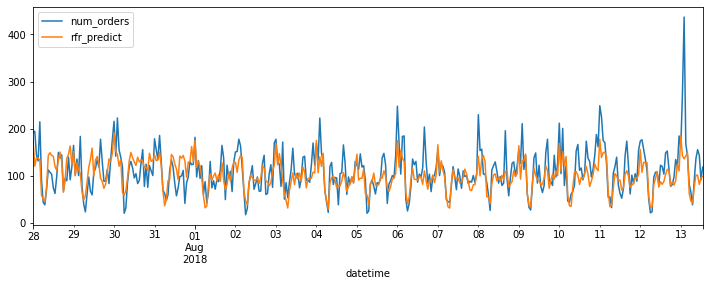

In [ ]:
df_final.plot(figsize=(12,4))